Import data and downsample for every 150th datapoint. Visualize the terrain. Flatten x and y to create a design matrix.

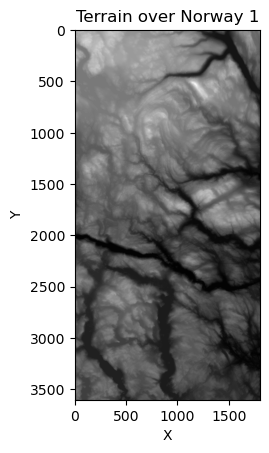

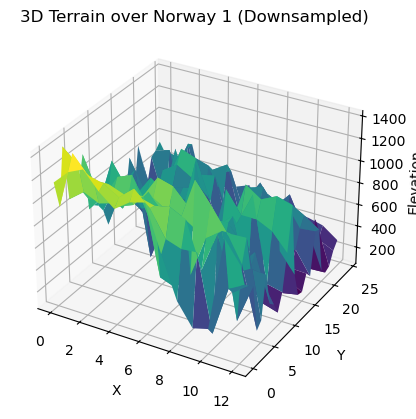

In [1]:
import numpy as np
from imageio.v2 import imread
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Load the terrain
terrain1 = imread('SRTM_data_Norway_1.tif')
# Show the terrain
plt.figure()
plt.title('Terrain over Norway 1')
plt.imshow(terrain1, cmap='gray')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Use data points from TIFF file
terrain1_array = np.array(terrain1)
# Downsample the data by selecting every 150th point
downsample_factor = 150
terrain1_downsampled = terrain1[::downsample_factor, ::downsample_factor]

# Create meshgrid
ysize, xsize = terrain1_downsampled.shape
x = np.linspace(0, xsize - 1, xsize)
y = np.linspace(0, ysize - 1, ysize)
x, y = np.meshgrid(x, y)

# Flatten x and y to create a design matrix
x_flat = x.flatten()
y_flat = y.flatten()

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, terrain1_downsampled, cmap=cm.viridis)

ax.set_title('3D Terrain over Norway 1 (Downsampled)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Elevation')

plt.show()

OLS on this data

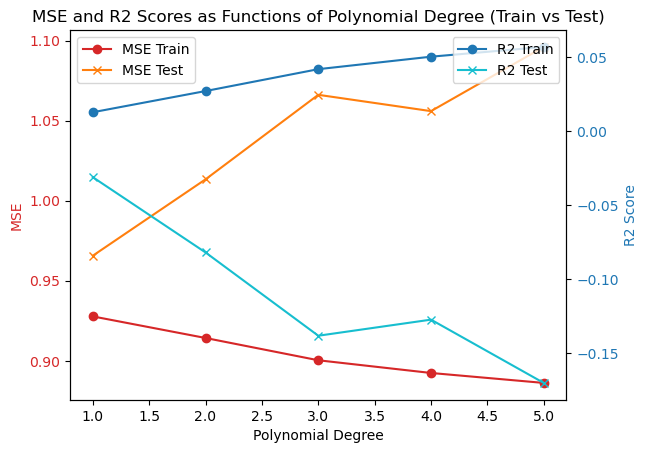

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Define the Franke function (as used before)
def FrankeFunction(x, y):
    term1 = 0.75 * np.exp(-(0.25 * (9*x - 2)**2) - 0.25 * ((9*y - 2)**2))
    term2 = 0.75 * np.exp(-((9*x + 1)**2) / 49.0 - 0.1 * (9*y + 1))
    term3 = 0.5 * np.exp(-(9*x - 7)**2 / 4.0 - 0.25 * ((9*y - 3)**2))
    term4 = -0.2 * np.exp(-(9*x - 4)**2 - (9*y - 7)**2)
    return term1 + term2 + term3 + term4

# Use data points from TIFF file
terrain1_array = np.array(terrain1)
# Downsample the data by selecting every 150th point
downsample_factor = 150
terrain1_downsampled = terrain1[::downsample_factor, ::downsample_factor]

# Create meshgrid
ysize, xsize = terrain1_downsampled.shape
x = np.linspace(0, xsize - 1, xsize)
y = np.linspace(0, ysize - 1, ysize)
x, y = np.meshgrid(x, y)

# Flatten x and y to create a design matrix
x_flat = x.flatten()
y_flat = y.flatten()
# Compute Franke function and add noise
z = FrankeFunction(x, y)
np.random.seed(42)
noise = np.random.normal(0, 1, z.shape)
z_noisy = z + noise
z_noisy_flat = z_noisy.flatten()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    x_flat, y_flat, z_noisy_flat, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

'''# Standardize the data using Scikit-learn's StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)'''

# Function to create a design matrix for polynomial terms up to a given degree
def create_design_matrix(x, y, degree):
    N = len(x)
    num_terms = (degree + 1) * (degree + 2) // 2  # Number of polynomial terms up to the given degree
    X = np.ones((N, num_terms))  # Initialize the design matrix
    index = 1
    for i in range(1, degree+1):
        for j in range(i+1):
            X[:, index] = (x ** (i-j)) * (y ** j)
            index += 1
    return X

# Lists to store MSE, R2 scores, and beta coefficients
degrees = list(range(1, 6))  # Degrees from 1 to 5
mse_train_scores = []
mse_test_scores = []
r2_train_scores = []
r2_test_scores = []
betas = []  # List to store the beta coefficients for each degree

# Loop over different polynomial degrees
for degree in degrees:
    # Create the design matrix for the current degree for training and testing data
    X_train = create_design_matrix(x_train.flatten(), y_train.flatten(), degree)
    X_test = create_design_matrix(x_test.flatten(), y_test.flatten(), degree)
    
    # Perform the OLS regression using the normal equation
    X_train_T = X_train.T
    beta = inv(X_train_T @ X_train) @ X_train_T @ z_train
    
    # Predict values based on the OLS model
    z_train_pred = X_train @ beta
    z_test_pred = X_test @ beta
    
    # Compute MSE and R2 scores for both training and test data
    mse_train = mean_squared_error(z_train, z_train_pred)
    mse_test = mean_squared_error(z_test, z_test_pred)
    r2_train = r2_score(z_train, z_train_pred)
    r2_test = r2_score(z_test, z_test_pred)
    
    # Append the scores to the lists
    mse_train_scores.append(mse_train)
    mse_test_scores.append(mse_test)
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)
    
    # Store the beta coefficients
    betas.append(beta)

# Convert the list of beta coefficients into an array for plotting
betas = np.array(betas, dtype=object).flatten()

# Plot the MSE and R2 as functions of the polynomial degree
fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel('Polynomial Degree')
ax1.set_ylabel('MSE', color='tab:red')
ax1.plot(degrees, mse_train_scores, 'o-', color='tab:red', label='MSE Train')
ax1.plot(degrees, mse_test_scores, 'x-', color='tab:orange', label='MSE Test')
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for R2
ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(degrees, r2_train_scores, 'o-', color='tab:blue', label='R2 Train')
ax2.plot(degrees, r2_test_scores, 'x-', color='tab:cyan', label='R2 Test')
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title and show the plot
plt.title('MSE and R2 Scores as Functions of Polynomial Degree (Train vs Test)')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()

Ridge regression

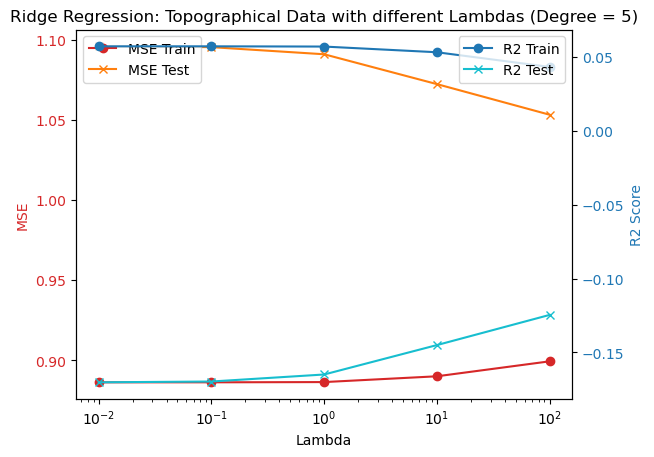

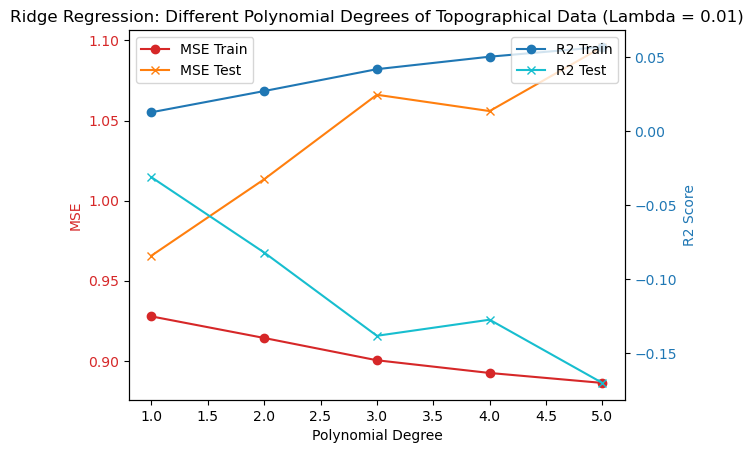

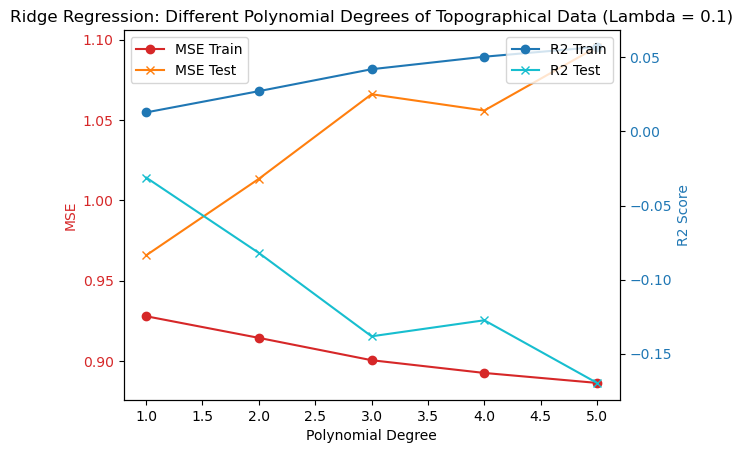

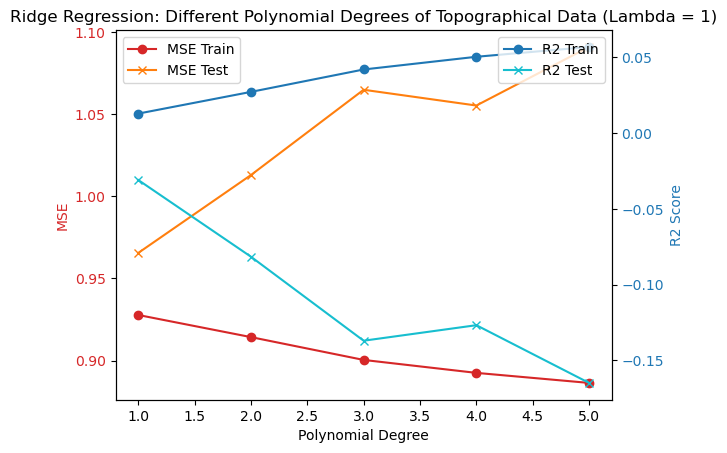

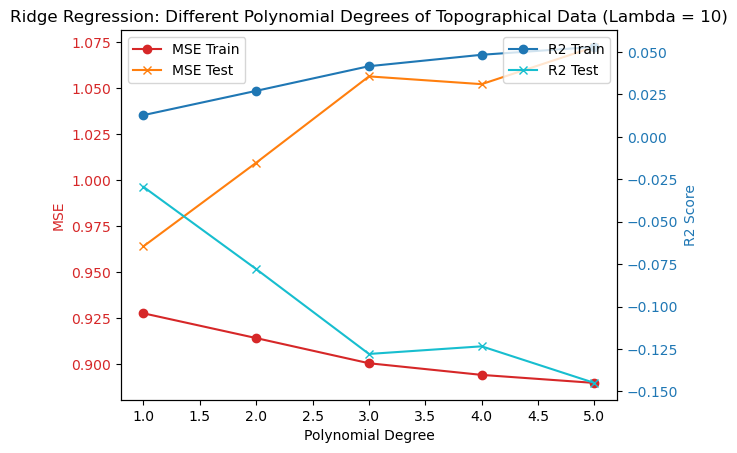

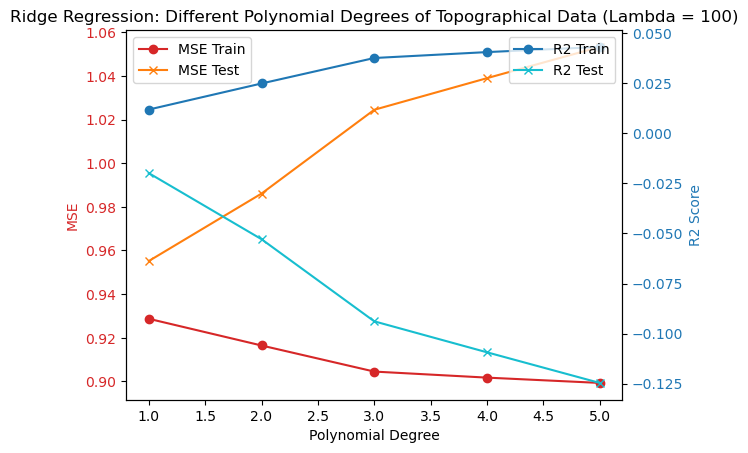

In [5]:
# Use data points from TIFF file
terrain1_array = np.array(terrain1)
# Downsample the data by selecting every 150th point
downsample_factor = 150
terrain1_downsampled = terrain1[::downsample_factor, ::downsample_factor]

# Create meshgrid
ysize, xsize = terrain1_downsampled.shape
x = np.linspace(0, xsize - 1, xsize)
y = np.linspace(0, ysize - 1, ysize)
x, y = np.meshgrid(x, y)

# Flatten x and y to create a design matrix
x_flat = x.flatten()
y_flat = y.flatten()

# Compute Franke function and add noise
z = FrankeFunction(x, y)
np.random.seed(42)
noise = np.random.normal(0, 1, z.shape)
z_noisy = z + noise
z_noisy_flat = z_noisy.flatten()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    x_flat, y_flat, z_noisy_flat, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Standardize the data using Scikit-learn's StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Function to create a design matrix for polynomial terms up to a given degree
def create_design_matrix(x, y, degree):
    N = len(x)
    num_terms = (degree + 1) * (degree + 2) // 2  # Number of polynomial terms up to the given degree
    X = np.ones((N, num_terms))  # Initialize the design matrix
    index = 1
    for i in range(1, degree+1):
        for j in range(i+1):
            X[:, index] = (x ** (i-j)) * (y ** j)
            index += 1
    return X

# ================== Plot 1: MSE and R2 as functions of lambda ==================

# Define the lambda values to be tested
lambda_values = [10**-2, 10**-1, 10**0, 10**1, 10**2]

# Lists to store MSE and R2 scores, and beta coefficients
mse_train_scores = []
mse_test_scores = []
r2_train_scores = []
r2_test_scores = []
betas_ridge_regression = []

degree = 5  # Set degree to 5 for this plot

# Loop over different values of lambda
for lambda_val in lambda_values:
    # Create the design matrix for the current degree (we use 5th degree polynomial for this example)
    X_train = create_design_matrix(x_train_scaled.flatten(), y_train_scaled.flatten(), degree)
    X_test = create_design_matrix(x_test_scaled.flatten(), y_test_scaled.flatten(), degree)
    
    # Perform Ridge regression using the normal equation
    X_train_T = X_train.T
    identity_matrix = np.eye(X_train.shape[1])
    beta = inv(X_train_T @ X_train + lambda_val * identity_matrix) @ X_train_T @ z_train
    
    # Predict values based on the Ridge model
    z_train_pred = X_train @ beta
    z_test_pred = X_test @ beta
    
    # Compute MSE and R2 scores for both training and test data
    mse_train = mean_squared_error(z_train, z_train_pred)
    mse_test = mean_squared_error(z_test, z_test_pred)
    r2_train = r2_score(z_train, z_train_pred)
    r2_test = r2_score(z_test, z_test_pred)
    
    # Append the scores to the lists
    mse_train_scores.append(mse_train)
    mse_test_scores.append(mse_test)
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)
    
    
# Cinvert list of beta coefficients into an array for plotting
betas_ridge_regression = np.array(betas_ridge_regression, dtype=object)

# Plot the MSE and R2 as functions of lambda
fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel('Lambda')
ax1.set_ylabel('MSE', color='tab:red')
ax1.plot(lambda_values, mse_train_scores, 'o-', color='tab:red', label='MSE Train')
ax1.plot(lambda_values, mse_test_scores, 'x-', color='tab:orange', label='MSE Test')
ax1.set_xscale('log')  # Log scale for lambda
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for R2
ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(lambda_values, r2_train_scores, 'o-', color='tab:blue', label='R2 Train')
ax2.plot(lambda_values, r2_test_scores, 'x-', color='tab:cyan', label='R2 Test')
ax2.set_xscale('log')  # Log scale for lambda
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title and show the plot
plt.title('Ridge Regression: Topographical Data with different Lambdas (Degree = 5)')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


# ================== Plot 2: MSE and R2 as functions of polynomial degree ==================

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define lambda values
lambda_values = [10**-2, 10**-1, 10**0, 10**1, 10**2]

# Define the range of polynomial degrees to test
degree_values = [1, 2, 3, 4, 5]

# Iterate over each lambda value to generate independent plots
for lambda_val in lambda_values:
    # Lists to store MSE and R2 scores for different polynomial degrees
    mse_train_degrees = []
    mse_test_degrees = []
    r2_train_degrees = []
    r2_test_degrees = []

    # Loop over different polynomial degrees
    for degree in degree_values:
        # Create the design matrix for the current degree
        X_train = create_design_matrix(x_train_scaled.flatten(), y_train_scaled.flatten(), degree)
        X_test = create_design_matrix(x_test_scaled.flatten(), y_test_scaled.flatten(), degree)
        
        # Perform Ridge regression using the normal equation
        X_train_T = X_train.T
        identity_matrix = np.eye(X_train.shape[1])
        beta = inv(X_train_T @ X_train + lambda_val * identity_matrix) @ X_train_T @ z_train
        
        # Predict values based on the Ridge model
        z_train_pred = X_train @ beta
        z_test_pred = X_test @ beta
        
        # Compute MSE and R2 scores for both training and test data
        mse_train = mean_squared_error(z_train, z_train_pred)
        mse_test = mean_squared_error(z_test, z_test_pred)
        r2_train = r2_score(z_train, z_train_pred)
        r2_test = r2_score(z_test, z_test_pred)
        
        # Append the scores to the lists
        mse_train_degrees.append(mse_train)
        mse_test_degrees.append(mse_test)
        r2_train_degrees.append(r2_train)
        r2_test_degrees.append(r2_test)

    # Create the plot for the current lambda value
    fig, ax1 = plt.subplots()

    # Plot MSE on the left y-axis
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE', color='tab:red')
    ax1.plot(degree_values, mse_train_degrees, 'o-', color='tab:red', label='MSE Train')
    ax1.plot(degree_values, mse_test_degrees, 'x-', color='tab:orange', label='MSE Test')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for R2
    ax2 = ax1.twinx()
    ax2.set_ylabel('R2 Score', color='tab:blue')
    ax2.plot(degree_values, r2_train_degrees, 'o-', color='tab:blue', label='R2 Train')
    ax2.plot(degree_values, r2_test_degrees, 'x-', color='tab:cyan', label='R2 Test')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title and show the plot
    plt.title(f'Ridge Regression: Different Polynomial Degrees of Topographical Data (Lambda = {lambda_val})')
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()


Lasso regression

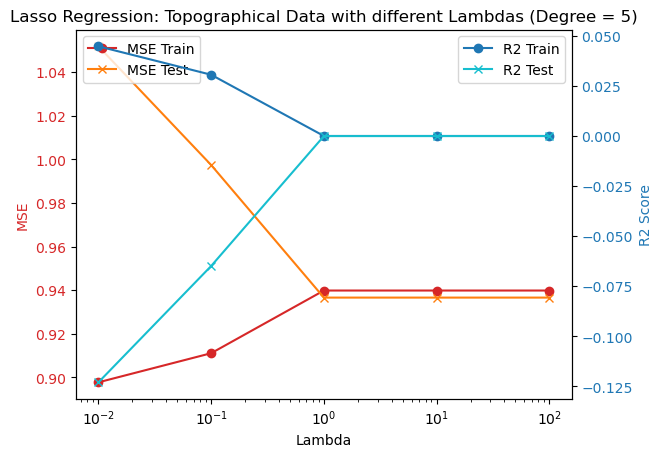

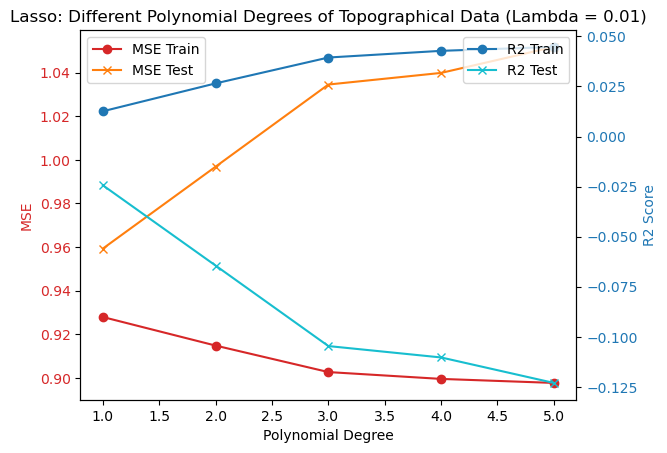

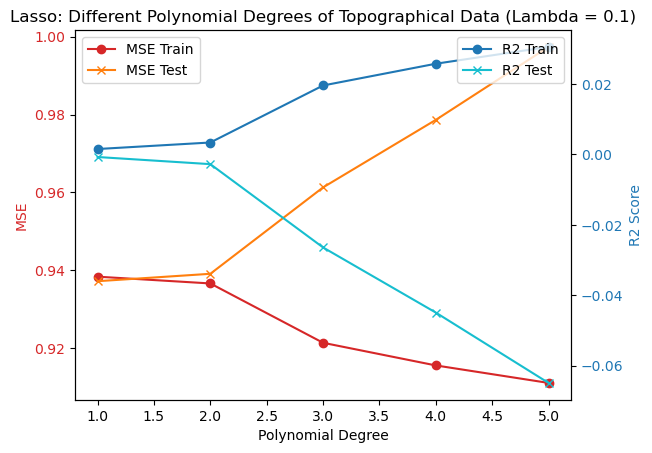

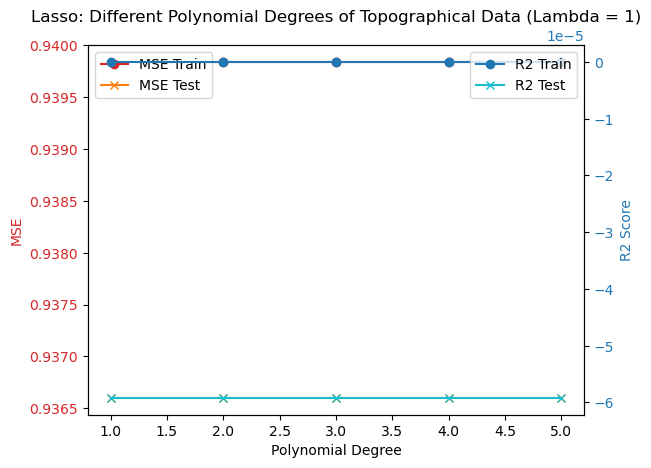

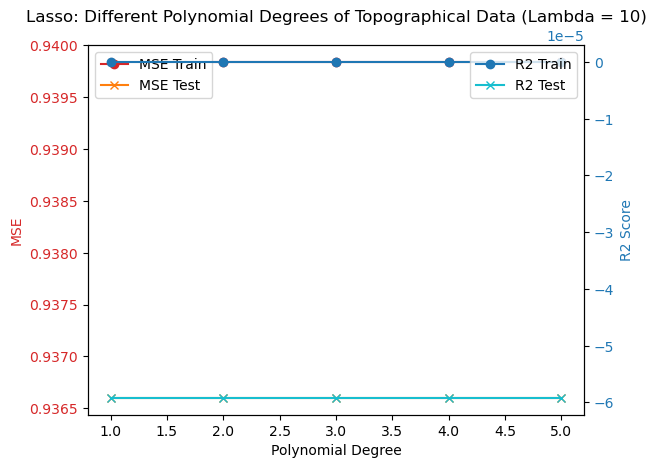

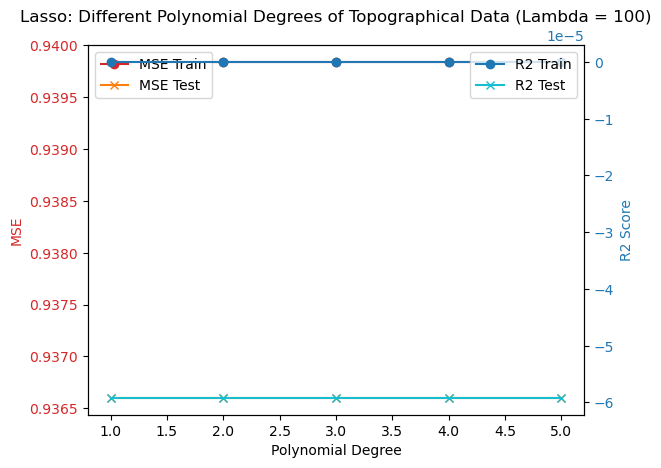

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso

# Use data points from TIFF file
terrain1_array = np.array(terrain1)
# Downsample the data by selecting every 150th point
downsample_factor = 150
terrain1_downsampled = terrain1[::downsample_factor, ::downsample_factor]

# Create meshgrid
ysize, xsize = terrain1_downsampled.shape
x = np.linspace(0, xsize - 1, xsize)
y = np.linspace(0, ysize - 1, ysize)
x, y = np.meshgrid(x, y)

# Flatten x and y to create a design matrix
x_flat = x.flatten()
y_flat = y.flatten()

# Compute Franke function and add noise
z = FrankeFunction(x, y)
np.random.seed(42)
noise = np.random.normal(0, 1, z.shape)
z_noisy = z + noise
z_noisy_flat = z_noisy.flatten()

# Split the data into training and testing sets
x_train, x_test, y_train, y_test, z_train, z_test = train_test_split(
    x_flat, y_flat, z_noisy_flat, test_size=0.2, random_state=42)

# Reshape the data to 2D arrays
x_train = x_train.reshape(-1, 1)
x_test = x_test.reshape(-1, 1)
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

# Standardize the data using Scikit-learn's StandardScaler
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x_train_scaled = scaler_x.fit_transform(x_train)
x_test_scaled = scaler_x.transform(x_test)
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Function to create a design matrix for polynomial terms up to a given degree
def create_design_matrix(x, y, degree):
    N = len(x)
    num_terms = (degree + 1) * (degree + 2) // 2  # Number of polynomial terms up to the given degree
    X = np.ones((N, num_terms))  # Initialize the design matrix
    index = 1
    for i in range(1, degree+1):
        for j in range(i+1):
            X[:, index] = (x ** (i-j)) * (y ** j)
            index += 1
    return X

# ================== Plot 1: MSE and R2 as functions of lambda ==================

# Define the lambda values to be tested
lambda_values = [10**-2, 10**-1, 10**0, 10**1, 10**2]

# Lists to store MSE and R2 scores, and beta coefficients
mse_train_scores = []
mse_test_scores = []
r2_train_scores = []
r2_test_scores = []
betas_lasso = []

degree = 5  # Set degree to 5 for this plot

# Loop over different values of lambda
for lambda_val in lambda_values:
    # Create the design matrix for the current degree (we use 5th degree polynomial for this example)
    X_train = create_design_matrix(x_train_scaled.flatten(), y_train_scaled.flatten(), degree)
    X_test = create_design_matrix(x_test_scaled.flatten(), y_test_scaled.flatten(), degree)

    # Perform Lasso regression using scikit-learn's Lasso model
    lasso_model = Lasso(alpha=lambda_val, max_iter=10000)  # alpha corresponds to lambda
    lasso_model.fit(X_train, z_train)  # Fit the Lasso model to the training data

    # Get the beta coefficients from the trained model (optional, for inspection)
    beta = lasso_model.coef_

    # Predict values based on the Lasso model
    z_train_pred = lasso_model.predict(X_train)
    z_test_pred = lasso_model.predict(X_test)
    
    # Compute MSE and R2 scores for both training and test data
    mse_train = mean_squared_error(z_train, z_train_pred)
    mse_test = mean_squared_error(z_test, z_test_pred)
    r2_train = r2_score(z_train, z_train_pred)
    r2_test = r2_score(z_test, z_test_pred)
    
    # Append the scores to the lists
    mse_train_scores.append(mse_train)
    mse_test_scores.append(mse_test)
    r2_train_scores.append(r2_train)
    r2_test_scores.append(r2_test)
    
    # Store beta coefficients
    betas_lasso.append(beta)
    
# Convert list of beta coefficients into an array for plotting
betas_lasso = np.array(betas_lasso, dtype=object)


# Plot the MSE and R2 as functions of lambda
fig, ax1 = plt.subplots()

# Plot MSE on the left y-axis
ax1.set_xlabel('Lambda')
ax1.set_ylabel('MSE', color='tab:red')
ax1.plot(lambda_values, mse_train_scores, 'o-', color='tab:red', label='MSE Train')
ax1.plot(lambda_values, mse_test_scores, 'x-', color='tab:orange', label='MSE Test')
ax1.set_xscale('log')  # Log scale for lambda
ax1.tick_params(axis='y', labelcolor='tab:red')

# Create a second y-axis for R2
ax2 = ax1.twinx()
ax2.set_ylabel('R2 Score', color='tab:blue')
ax2.plot(lambda_values, r2_train_scores, 'o-', color='tab:blue', label='R2 Train')
ax2.plot(lambda_values, r2_test_scores, 'x-', color='tab:cyan', label='R2 Test')
ax2.set_xscale('log')  # Log scale for lambda
ax2.tick_params(axis='y', labelcolor='tab:blue')

# Add a title and show the plot
plt.title('Lasso Regression: Topographical Data with different Lambdas (Degree = 5)')
ax1.legend(loc="upper left")
ax2.legend(loc="upper right")
plt.show()


# ================== Plot 2: MSE and R2 as functions of polynomial degree ==================

import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Define lambda values
lambda_values = [10**-2, 10**-1, 10**0, 10**1, 10**2]

# Define the range of polynomial degrees to test
degree_values = [1, 2, 3, 4, 5]

betas_lasso = []

# Iterate over each lambda value to generate independent plots
for lambda_val in lambda_values:
    # Lists to store MSE and R2 scores for different polynomial degrees
    mse_train_degrees = []
    mse_test_degrees = []
    r2_train_degrees = []
    r2_test_degrees = []

    # Loop over different polynomial degrees
    for degree in degree_values:
        # Create the design matrix for the current degree
        X_train = create_design_matrix(x_train_scaled.flatten(), y_train_scaled.flatten(), degree)
        X_test = create_design_matrix(x_test_scaled.flatten(), y_test_scaled.flatten(), degree)
        
        # Perform Lasso regression using scikit-learn's Lasso model
        lasso_model = Lasso(alpha=lambda_val, max_iter=10000)  # alpha corresponds to lambda
        lasso_model.fit(X_train, z_train)  # Fit the Lasso model to the training data

        # Get the beta coefficients from the trained model (optional, for inspection)
        beta = lasso_model.coef_

        # Predict values based on the Lasso model
        z_train_pred = lasso_model.predict(X_train)
        z_test_pred = lasso_model.predict(X_test)
        
        # Compute MSE and R2 scores for both training and test data
        mse_train = mean_squared_error(z_train, z_train_pred)
        mse_test = mean_squared_error(z_test, z_test_pred)
        r2_train = r2_score(z_train, z_train_pred)
        r2_test = r2_score(z_test, z_test_pred)
        
        # Append the scores to the lists
        mse_train_degrees.append(mse_train)
        mse_test_degrees.append(mse_test)
        r2_train_degrees.append(r2_train)
        r2_test_degrees.append(r2_test)
        
        # Store beta coefficients:
        if lambda_val == 10:
            betas_lasso.append(beta)

    # Create the plot for the current lambda value
    fig, ax1 = plt.subplots()

    # Plot MSE on the left y-axis
    ax1.set_xlabel('Polynomial Degree')
    ax1.set_ylabel('MSE', color='tab:red')
    ax1.plot(degree_values, mse_train_degrees, 'o-', color='tab:red', label='MSE Train')
    ax1.plot(degree_values, mse_test_degrees, 'x-', color='tab:orange', label='MSE Test')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    # Create a second y-axis for R2
    ax2 = ax1.twinx()
    ax2.set_ylabel('R2 Score', color='tab:blue')
    ax2.plot(degree_values, r2_train_degrees, 'o-', color='tab:blue', label='R2 Train')
    ax2.plot(degree_values, r2_test_degrees, 'x-', color='tab:cyan', label='R2 Test')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    # Add a title and show the plot
    plt.title(f'Lasso: Different Polynomial Degrees of Topographical Data (Lambda = {lambda_val})')
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()

